### Conditional Deep Convolutional Generative Adversarial Network
view https://arxiv.org/pdf/1605.05396.pdf

In [1]:
import torch
from torch import nn
import torchvision.datasets
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor #uncomment if using gpu
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.backends.cudnn.benchmark = True

In [3]:
batch_size = 128
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

In [4]:
transform = torchvision.transforms.ToTensor()
mnist_train = torchvision.datasets.MNIST('./MNIST_data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size)
mnist_test = torchvision.datasets.MNIST('./MNIST_data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size)

In [5]:
class Flatten(nn.Module):
    def forward(self, input):
        flattened = input.view(input.shape[0], -1)
        return flattened

In [6]:
class Unflatten(nn.Module):
    def __init__(self, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.C = C
        self.H = H
        self.W = W
        
    def forward(self, input):
        unflattened = input.view(-1, self.C, self.H, self.W)
        return unflattened

In [7]:
class Add_Conditional(nn.Module):
#     def __init__(self):
#         super(Add_Conditional, self).__init__()
        
    def forward(self, input, conditional=None):
        conditional_array = np.expand_dims(np.array(conditional), axis=1)
#         conditional_tensor = torch.FloatTensor(conditional_array)
        conditional_tensor = torch.cuda.FloatTensor(conditional_array)
        concatenated = torch.cat((conditional_tensor, input), dim=1)
        return concatenated

In [8]:
def generate_noise(batch_size, dim=96):
    noise = torch.rand(batch_size, dim) * 2 - 1
    return noise

    nn.Conv2d(1, 32, [5,5], stride=[1,1]),
    nn.LeakyReLU(negative_slope=.01),
    nn.MaxPool2d([2,2], stride=[2,2]),
    nn.Conv2d(32, 64, [5,5], stride=[1,1]),
    nn.LeakyReLU(negative_slope=.01),
    nn.MaxPool2d([2,2], stride=[2,2]),
    Flatten(),
    Add_Conditional(conditional=conditional),
    nn.Linear((4*4*64 + 1), (4*4*64)), 
    nn.LeakyReLU(negative_slope=.01),
    nn.Linear((4*4*64), 1)

In [9]:
class CNN(nn.Module):
    def __init__(self, conditional):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, [5,5], stride=[1,1]),
            nn.LeakyReLU(negative_slope=.01),
            nn.MaxPool2d([2,2], stride=[2,2])
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, [5,5], stride=[1,1]),
            nn.LeakyReLU(negative_slope=.01),
            nn.MaxPool2d([2,2], stride=[2,2])
        )
        self.flatten = Flatten()
        self.condition_concat = Add_Conditional()
        self.linear_layers = nn.Sequential(
            nn.Linear((4*4*64), (4*4*64)), 
            nn.LeakyReLU(negative_slope=.01),
            nn.Linear((4*4*64), 10)
        )
    
    def forward(self, x, conditional):
#         out = self.condition_concat(x, conditional=conditional)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.linear_layers(out)
#         print("Conditional CNN", conditional.shape) 
        return out

    nn.Linear(noise_dim, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    Add_Conditional(conditional=conditional),
    nn.Linear(1025, (7*7*128)),
    nn.ReLU(),
    nn.BatchNorm1d(7*7*128),
    Unflatten(C=128, H=7, W=7),
    nn.ConvTranspose2d(128, 64, [4,4], stride=[2,2], padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64, 1, [4,4], stride=[2,2], padding=1),
    nn.Tanh(),
    Flatten()

In [10]:
class Generator(nn.Module):
    def __init__(self, conditional, noise_dim=96):
        super(Generator, self).__init__()
        self.conditional_concat = Add_Conditional()
        self.layer1 = nn.Sequential(
            nn.Linear(noise_dim + 1, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(1024, (7*7*128)),
            nn.ReLU(),
            nn.BatchNorm1d(7*7*128)
        )
        self.unflatten = Unflatten(C=128, H=7, W=7)
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, [4,4], stride=[2,2], padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.layer4 = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, [4,4], stride=[2,2], padding=1),
            nn.Tanh(),
        )
        self.flatten = Flatten()
        
    def forward(self, x, conditional, noise_dim=96):
        out = self.conditional_concat(x, conditional=conditional)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.unflatten(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.flatten(out)
        return out

In [11]:
def create_optimizer(model, lr=.01, betas=None):
    if betas == None:
        optimizer = torch.optim.Adam(model, lr=lr)
    else:
        optimizer = torch.optim.Adam(model, lr=lr, betas=betas)
    return optimizer

In [12]:
def discriminator_loss(scores_real, scores_fake):
    true_labels = torch.ones_like(scores_real)
    valid_loss = torch.mean((scores_real - true_labels) ** 2) * .5
    invalid_loss = torch.mean(scores_fake ** 2) * .5
    loss = valid_loss + invalid_loss
    return loss

In [13]:
def generator_loss(scores_fake):
    true_labels = torch.ones_like(scores_fake)
    loss = torch.mean((scores_fake - true_labels) ** 2) * .5
    return loss

In [14]:
def show_image(images):
#     for image in images:
    images_np = images.cpu().detach().numpy().squeeze()
#     side_length = np.sqrt(images.shape[1])
#     print("side length", side_length, images.shape)
#     assert(side_length % 1 == 0), "images not square shape"
#     image_show = images[0]
#     image_unflattened = np.reshape(image_show, (int(side_length), int(side_length)))
#     plt.imshow(image_unflattened)
    plt.imshow(images_np[13])
    plt.show()

In [15]:
def get_probability(logits, labels):
#     print("type of logits", logits.dtype)
#     print("type of labels", labels.dtype)
    logits_sum = torch.sum(logits, dim=1) 
#     print("type of logits sum", logits_sum.dtype)
    logits_sum = logits_sum.view(logits_sum.shape[0], 1)
    logits_normalized = logits / logits_sum
    logits = logits[torch.arange(logits.shape[0]), labels]
#     print("logits shape", logits.shape)
#     print("logits sample", logits[0:3])
    return logits

In [16]:
def train_gan(generator, discriminator, image_loader, epochs, num_train_batches=-1):
    generator_optimizer = create_optimizer(generator.parameters(), lr=1e-3, betas=(.5, .999))
    discriminator_optimizer = create_optimizer(discriminator.parameters(), lr=1e-3, betas=(.5, .999))
    iters = 0
    for epoch in range(epochs):
        for i, (examples, labels) in enumerate(image_loader):
            if i == num_train_batches:
                break
            if labels.shape[0] != batch_size:
#                 print("invalid labels shape", labels.shape)
                continue
            examples = examples.cuda()
            labels = labels.cuda()
            generator_optimizer.zero_grad()
            discriminator_optimizer.zero_grad()
            z = generate_noise(batch_size).cuda()
            images_fake = generator(z, labels)
            images_fake_unflattened = images_fake.view(images_fake.shape[0], 1, 28, 28)
            scores_fake = discriminator(images_fake_unflattened, labels)
            scores_fake = get_probability(scores_fake, labels)
            ##TODO, fix scores_fake 10 class problem
            
            g_cost = generator_loss(scores_fake)
            g_cost.backward(retain_graph=True)
            generator_optimizer.step()

            scores_real = discriminator(examples, labels)
            scores_real = get_probability(scores_real, labels)
            d_cost = discriminator_loss(scores_real, scores_fake)
            d_cost.backward()
            discriminator_optimizer.step()
            iters += 1
            if iters % 1000  == 0:
                print("label", labels[13])
                print("Iteration:", iters)
                print("Discriminator Cost", d_cost)
                print("Generator Cost", g_cost)
                show_image(images_fake_unflattened)
                

    return generator, discriminator

In [17]:
filler_conditonal = torch.zeros(batch_size)
generator = Generator(filler_conditonal)
discriminator = CNN(filler_conditonal)
generator = generator.cuda()
discriminator = discriminator.cuda()
image_loader = train_loader
epochs = 250
num_train_batches = -1

label tensor(3)
Iteration: 1000
Discriminator Cost tensor(0.1521, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1039, grad_fn=<MulBackward>)


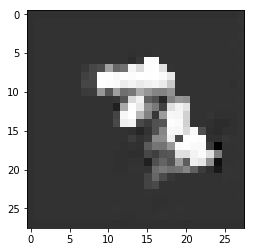

label tensor(2)
Iteration: 2000
Discriminator Cost tensor(0.1101, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1448, grad_fn=<MulBackward>)


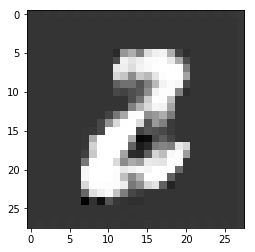

label tensor(1)
Iteration: 3000
Discriminator Cost tensor(0.1224, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1279, grad_fn=<MulBackward>)


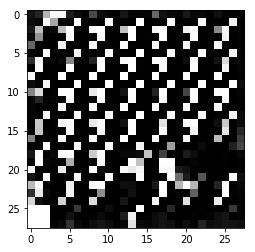

label tensor(3)
Iteration: 4000
Discriminator Cost tensor(0.1240, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1261, grad_fn=<MulBackward>)


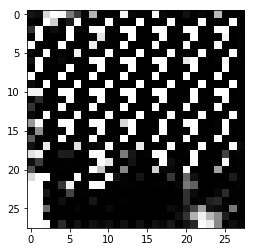

label tensor(6)
Iteration: 5000
Discriminator Cost tensor(0.1291, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1211, grad_fn=<MulBackward>)


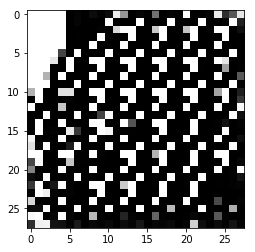

label tensor(1)
Iteration: 6000
Discriminator Cost tensor(0.1227, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1273, grad_fn=<MulBackward>)


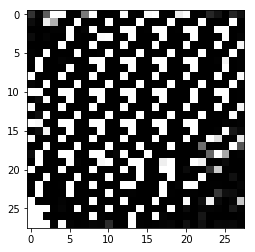

label tensor(4)
Iteration: 7000
Discriminator Cost tensor(0.1240, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1260, grad_fn=<MulBackward>)


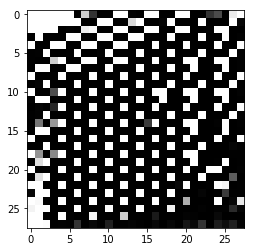

label tensor(6)
Iteration: 8000
Discriminator Cost tensor(0.1249, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1274, grad_fn=<MulBackward>)


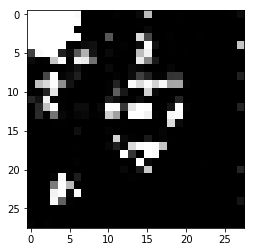

label tensor(6)
Iteration: 9000
Discriminator Cost tensor(0.1273, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1241, grad_fn=<MulBackward>)


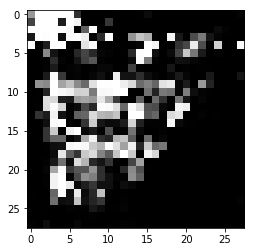

label tensor(6)
Iteration: 10000
Discriminator Cost tensor(0.1212, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1314, grad_fn=<MulBackward>)


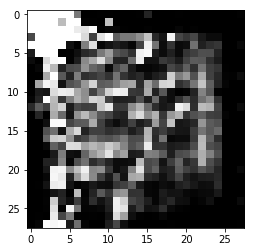

label tensor(3)
Iteration: 11000
Discriminator Cost tensor(0.1319, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1204, grad_fn=<MulBackward>)


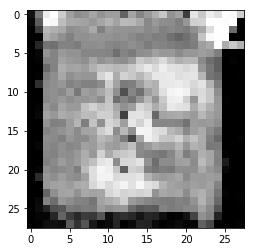

label tensor(5)
Iteration: 12000
Discriminator Cost tensor(0.1556, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1051, grad_fn=<MulBackward>)


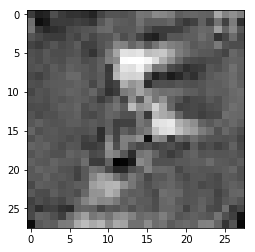

label tensor(9)
Iteration: 13000
Discriminator Cost tensor(0.1350, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1278, grad_fn=<MulBackward>)


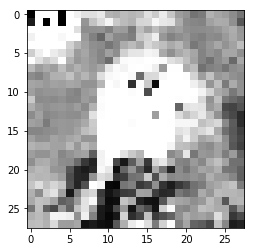

label tensor(7)
Iteration: 14000
Discriminator Cost tensor(0.1315, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1289, grad_fn=<MulBackward>)


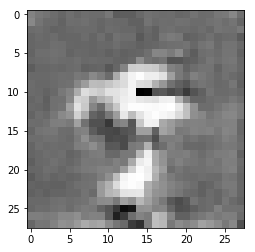

label tensor(1)
Iteration: 15000
Discriminator Cost tensor(0.1420, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1129, grad_fn=<MulBackward>)


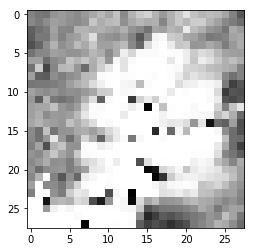

label tensor(8)
Iteration: 16000
Discriminator Cost tensor(0.1169, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1369, grad_fn=<MulBackward>)


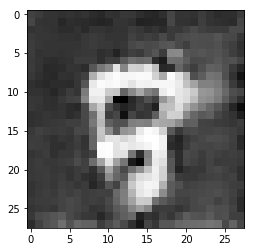

label tensor(7)
Iteration: 17000
Discriminator Cost tensor(0.1433, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1102, grad_fn=<MulBackward>)


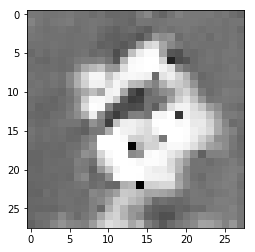

label tensor(9)
Iteration: 18000
Discriminator Cost tensor(0.1316, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1198, grad_fn=<MulBackward>)


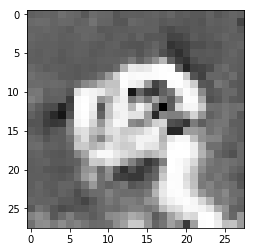

label tensor(4)
Iteration: 19000
Discriminator Cost tensor(0.1364, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1150, grad_fn=<MulBackward>)


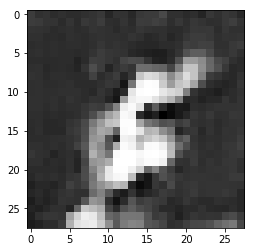

label tensor(7)
Iteration: 20000
Discriminator Cost tensor(0.1239, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1265, grad_fn=<MulBackward>)


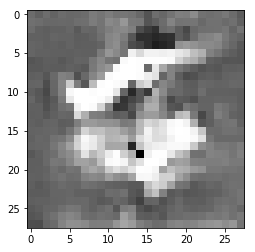

label tensor(2)
Iteration: 21000
Discriminator Cost tensor(0.1232, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1274, grad_fn=<MulBackward>)


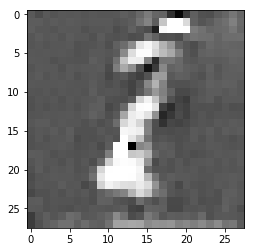

label tensor(1)
Iteration: 22000
Discriminator Cost tensor(0.1267, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1237, grad_fn=<MulBackward>)


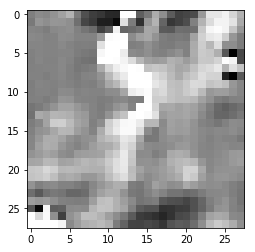

label tensor(1)
Iteration: 23000
Discriminator Cost tensor(0.1265, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1238, grad_fn=<MulBackward>)


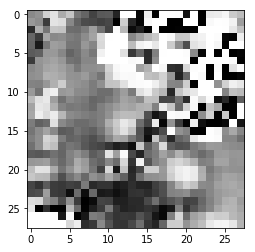

label tensor(2)
Iteration: 24000
Discriminator Cost tensor(0.1211, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1290, grad_fn=<MulBackward>)


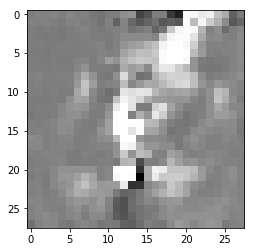

label tensor(1)
Iteration: 25000
Discriminator Cost tensor(0.1528, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1045, grad_fn=<MulBackward>)


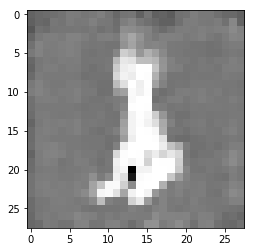

label tensor(4)
Iteration: 26000
Discriminator Cost tensor(0.1107, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1436, grad_fn=<MulBackward>)


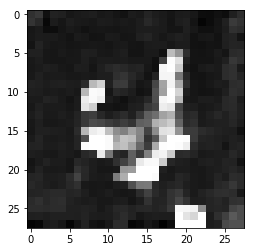

label tensor(0)
Iteration: 27000
Discriminator Cost tensor(0.1242, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1277, grad_fn=<MulBackward>)


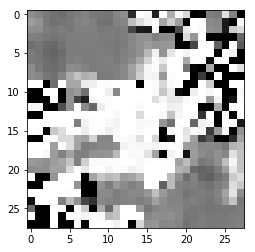

label tensor(9)
Iteration: 28000
Discriminator Cost tensor(0.1171, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1384, grad_fn=<MulBackward>)


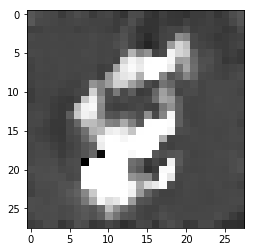

label tensor(8)
Iteration: 29000
Discriminator Cost tensor(0.1364, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1157, grad_fn=<MulBackward>)


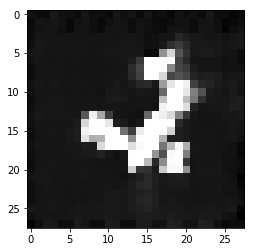

label tensor(6)
Iteration: 30000
Discriminator Cost tensor(0.1297, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1211, grad_fn=<MulBackward>)


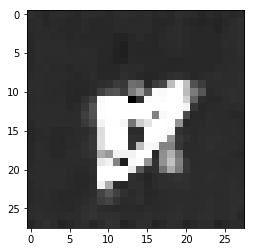

label tensor(1)
Iteration: 31000
Discriminator Cost tensor(0.1573, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1038, grad_fn=<MulBackward>)


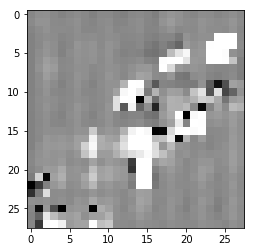

label tensor(3)
Iteration: 32000
Discriminator Cost tensor(0.1270, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1239, grad_fn=<MulBackward>)


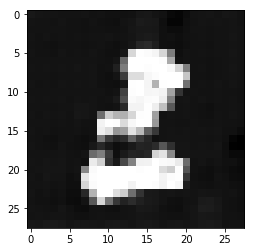

label tensor(0)
Iteration: 33000
Discriminator Cost tensor(0.1288, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1214, grad_fn=<MulBackward>)


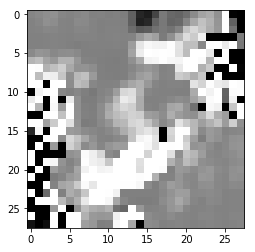

label tensor(3)
Iteration: 34000
Discriminator Cost tensor(0.1255, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1246, grad_fn=<MulBackward>)


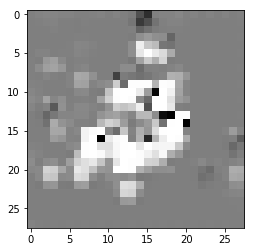

label tensor(5)
Iteration: 35000
Discriminator Cost tensor(0.1231, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1270, grad_fn=<MulBackward>)


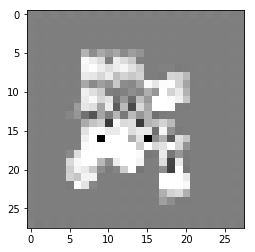

label tensor(4)
Iteration: 36000
Discriminator Cost tensor(0.1415, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1119, grad_fn=<MulBackward>)


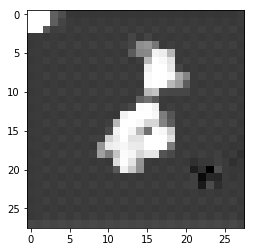

label tensor(7)
Iteration: 37000
Discriminator Cost tensor(0.1320, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1202, grad_fn=<MulBackward>)


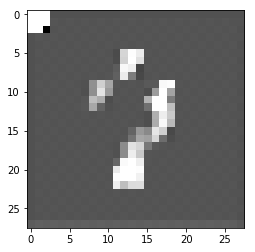

label tensor(0)
Iteration: 38000
Discriminator Cost tensor(0.1276, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1240, grad_fn=<MulBackward>)


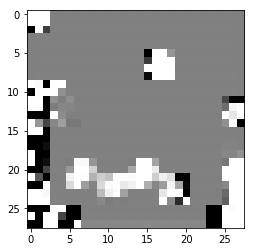

label tensor(4)
Iteration: 39000
Discriminator Cost tensor(0.1250, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1257, grad_fn=<MulBackward>)


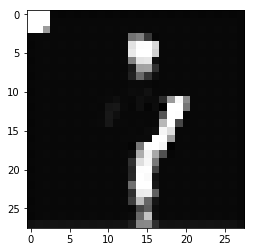

label tensor(8)
Iteration: 40000
Discriminator Cost tensor(0.1269, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1238, grad_fn=<MulBackward>)


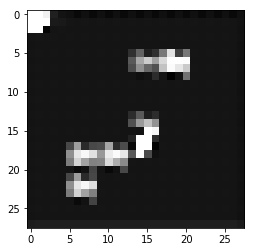

label tensor(6)
Iteration: 41000
Discriminator Cost tensor(0.1241, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1268, grad_fn=<MulBackward>)


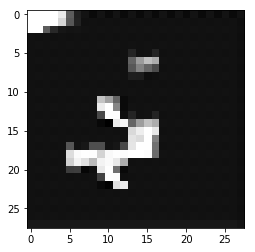

label tensor(9)
Iteration: 42000
Discriminator Cost tensor(0.1282, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1224, grad_fn=<MulBackward>)


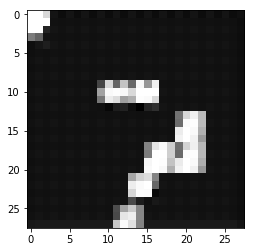

label tensor(0)
Iteration: 43000
Discriminator Cost tensor(0.1262, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1242, grad_fn=<MulBackward>)


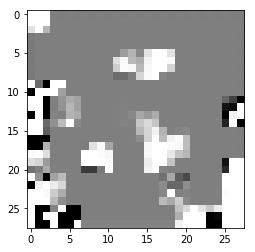

label tensor(3)
Iteration: 44000
Discriminator Cost tensor(0.1244, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1257, grad_fn=<MulBackward>)


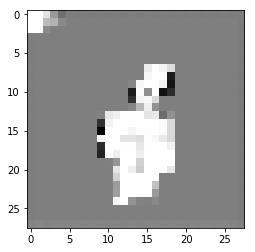

label tensor(0)
Iteration: 45000
Discriminator Cost tensor(0.1268, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1233, grad_fn=<MulBackward>)


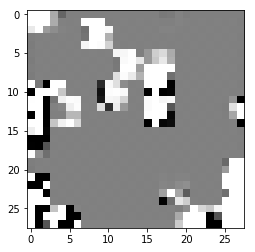

label tensor(0)
Iteration: 46000
Discriminator Cost tensor(0.1244, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1260, grad_fn=<MulBackward>)


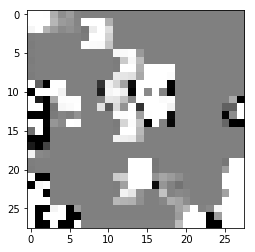

label tensor(1)
Iteration: 47000
Discriminator Cost tensor(0.1266, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1235, grad_fn=<MulBackward>)


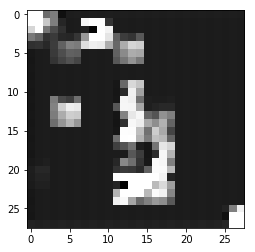

label tensor(0)
Iteration: 48000
Discriminator Cost tensor(0.1436, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1108, grad_fn=<MulBackward>)


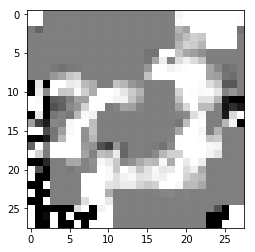

label tensor(6)
Iteration: 49000
Discriminator Cost tensor(0.1253, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1257, grad_fn=<MulBackward>)


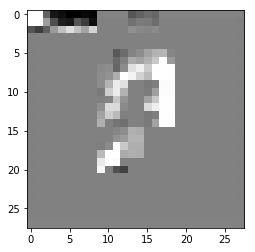

label tensor(0)
Iteration: 50000
Discriminator Cost tensor(0.1243, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1259, grad_fn=<MulBackward>)


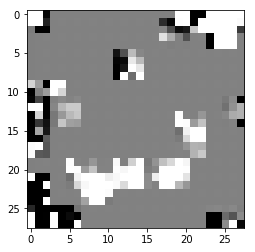

label tensor(1)
Iteration: 51000
Discriminator Cost tensor(0.1268, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1234, grad_fn=<MulBackward>)


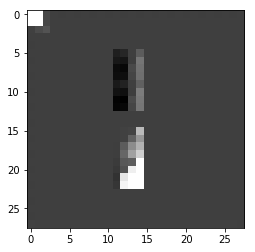

label tensor(6)
Iteration: 52000
Discriminator Cost tensor(0.1243, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1259, grad_fn=<MulBackward>)


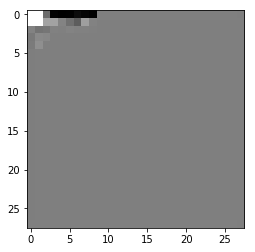

label tensor(8)
Iteration: 53000
Discriminator Cost tensor(0.1277, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1224, grad_fn=<MulBackward>)


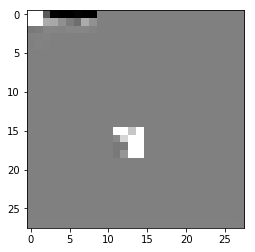

label tensor(9)
Iteration: 54000
Discriminator Cost tensor(0.1254, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1247, grad_fn=<MulBackward>)


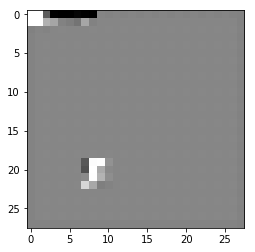

label tensor(3)
Iteration: 55000
Discriminator Cost tensor(0.1264, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1237, grad_fn=<MulBackward>)


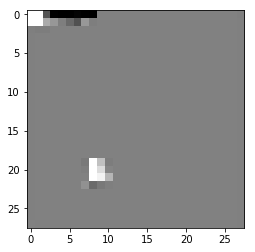

label tensor(0)
Iteration: 56000
Discriminator Cost tensor(0.1262, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1245, grad_fn=<MulBackward>)


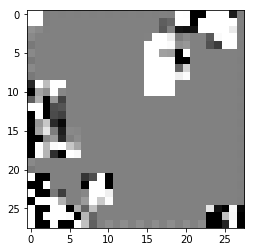

label tensor(1)
Iteration: 57000
Discriminator Cost tensor(0.0954, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1615, grad_fn=<MulBackward>)


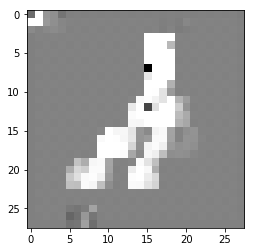

label tensor(7)
Iteration: 58000
Discriminator Cost tensor(0.1269, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1233, grad_fn=<MulBackward>)


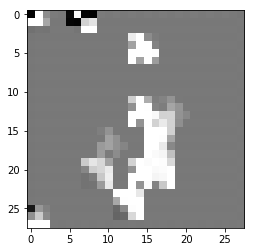

label tensor(2)
Iteration: 59000
Discriminator Cost tensor(0.1266, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1236, grad_fn=<MulBackward>)


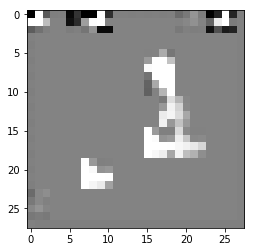

label tensor(8)
Iteration: 60000
Discriminator Cost tensor(0.1221, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1281, grad_fn=<MulBackward>)


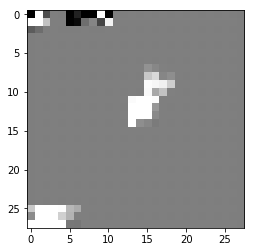

label tensor(1)
Iteration: 61000
Discriminator Cost tensor(0.1373, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1148, grad_fn=<MulBackward>)


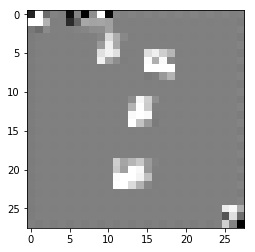

label tensor(1)
Iteration: 62000
Discriminator Cost tensor(0.1273, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1264, grad_fn=<MulBackward>)


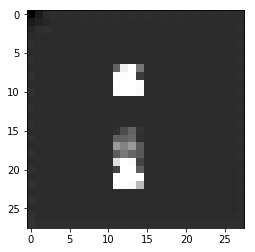

label tensor(0)
Iteration: 63000
Discriminator Cost tensor(0.1274, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1231, grad_fn=<MulBackward>)


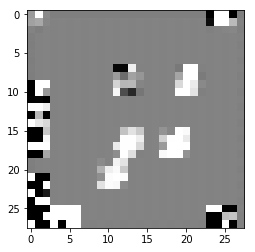

label tensor(6)
Iteration: 64000
Discriminator Cost tensor(0.1259, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1242, grad_fn=<MulBackward>)


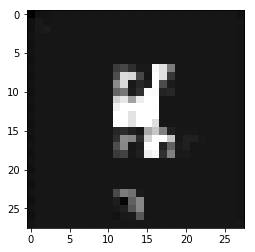

label tensor(8)
Iteration: 65000
Discriminator Cost tensor(2.7651, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1352, grad_fn=<MulBackward>)


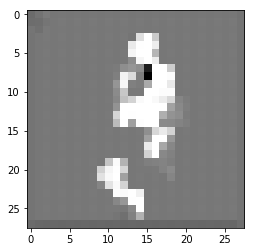

label tensor(9)
Iteration: 66000
Discriminator Cost tensor(0.1230, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1285, grad_fn=<MulBackward>)


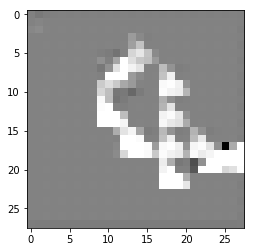

label tensor(9)
Iteration: 67000
Discriminator Cost tensor(0.1394, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1137, grad_fn=<MulBackward>)


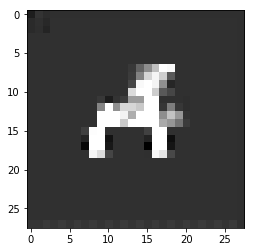

label tensor(2)
Iteration: 68000
Discriminator Cost tensor(0.0983, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1606, grad_fn=<MulBackward>)


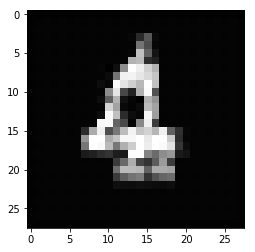

label tensor(5)
Iteration: 69000
Discriminator Cost tensor(0.1186, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1332, grad_fn=<MulBackward>)


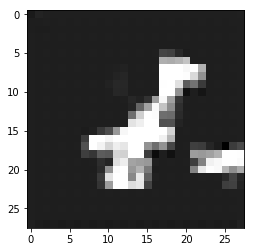

label tensor(6)
Iteration: 70000
Discriminator Cost tensor(0.1285, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1227, grad_fn=<MulBackward>)


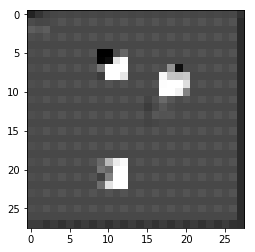

label tensor(6)
Iteration: 71000
Discriminator Cost tensor(0.1201, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1319, grad_fn=<MulBackward>)


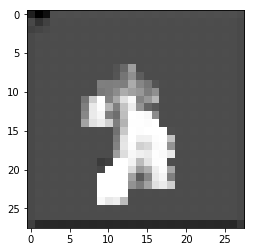

label tensor(5)
Iteration: 72000
Discriminator Cost tensor(0.1301, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1205, grad_fn=<MulBackward>)


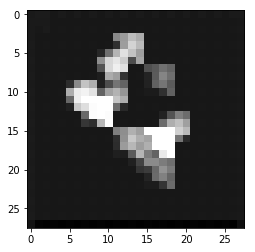

label tensor(0)
Iteration: 73000
Discriminator Cost tensor(0.1240, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1262, grad_fn=<MulBackward>)


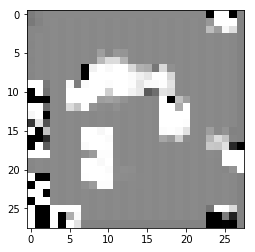

label tensor(9)
Iteration: 74000
Discriminator Cost tensor(0.1270, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1231, grad_fn=<MulBackward>)


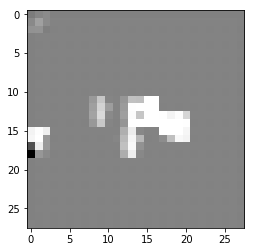

label tensor(3)
Iteration: 75000
Discriminator Cost tensor(0.1357, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1168, grad_fn=<MulBackward>)


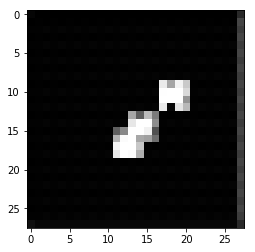

label tensor(8)
Iteration: 76000
Discriminator Cost tensor(0.1228, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1277, grad_fn=<MulBackward>)


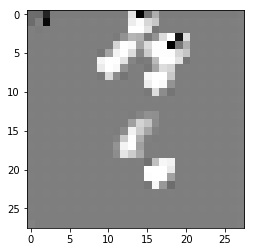

label tensor(6)
Iteration: 77000
Discriminator Cost tensor(0.1181, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1337, grad_fn=<MulBackward>)


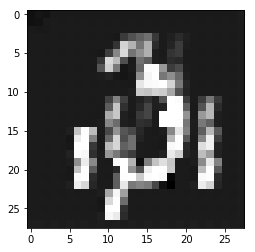

label tensor(7)
Iteration: 78000
Discriminator Cost tensor(0.1255, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1250, grad_fn=<MulBackward>)


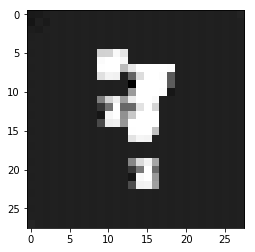

label tensor(4)
Iteration: 79000
Discriminator Cost tensor(0.1232, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1274, grad_fn=<MulBackward>)


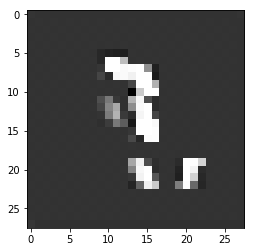

label tensor(9)
Iteration: 80000
Discriminator Cost tensor(0.1226, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1276, grad_fn=<MulBackward>)


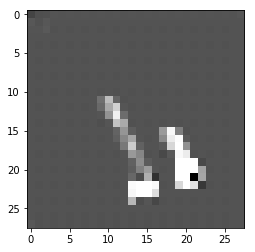

label tensor(4)
Iteration: 81000
Discriminator Cost tensor(0.1237, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1264, grad_fn=<MulBackward>)


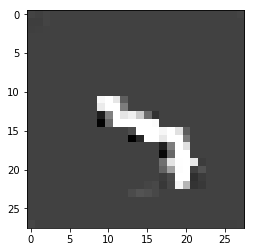

label tensor(6)
Iteration: 82000
Discriminator Cost tensor(0.1261, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1240, grad_fn=<MulBackward>)


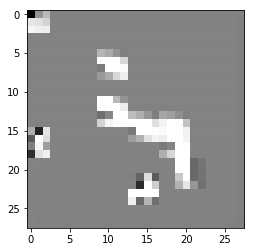

label tensor(0)
Iteration: 83000
Discriminator Cost tensor(0.1242, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1258, grad_fn=<MulBackward>)


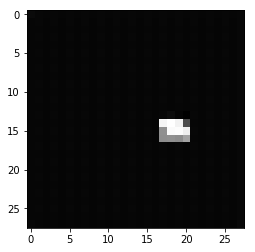

label tensor(1)
Iteration: 84000
Discriminator Cost tensor(0.1133, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1378, grad_fn=<MulBackward>)


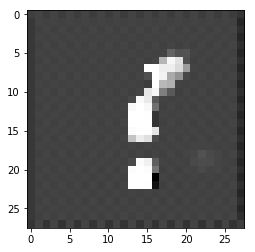

label tensor(0)
Iteration: 85000
Discriminator Cost tensor(0.1255, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1247, grad_fn=<MulBackward>)


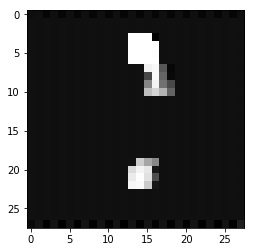

label tensor(2)
Iteration: 86000
Discriminator Cost tensor(0.1255, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1247, grad_fn=<MulBackward>)


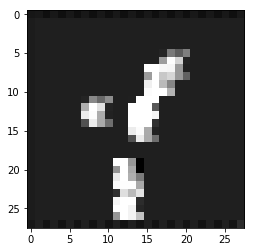

label tensor(9)
Iteration: 87000
Discriminator Cost tensor(0.1248, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1260, grad_fn=<MulBackward>)


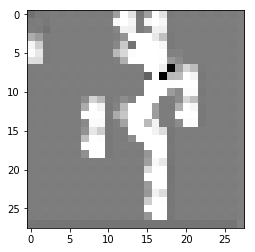

label tensor(7)
Iteration: 88000
Discriminator Cost tensor(0.1242, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1259, grad_fn=<MulBackward>)


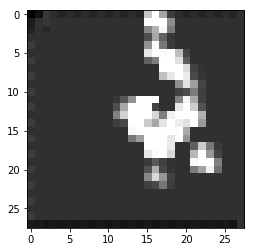

label tensor(3)
Iteration: 89000
Discriminator Cost tensor(0.1242, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1259, grad_fn=<MulBackward>)


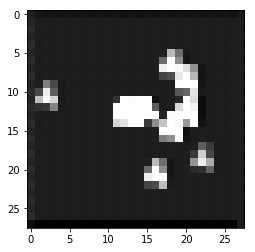

label tensor(8)
Iteration: 90000
Discriminator Cost tensor(0.1286, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1216, grad_fn=<MulBackward>)


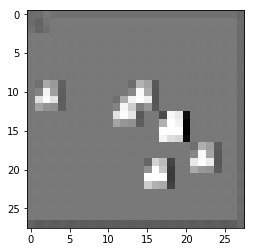

label tensor(2)
Iteration: 91000
Discriminator Cost tensor(0.1261, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1240, grad_fn=<MulBackward>)


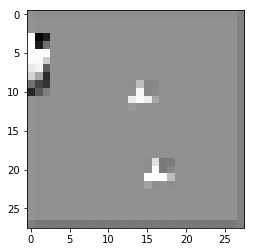

label tensor(3)
Iteration: 92000
Discriminator Cost tensor(0.1245, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1255, grad_fn=<MulBackward>)


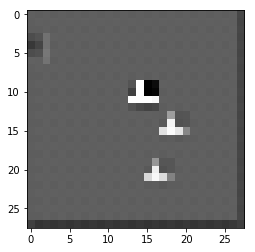

label tensor(1)
Iteration: 93000
Discriminator Cost tensor(0.1272, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1232, grad_fn=<MulBackward>)


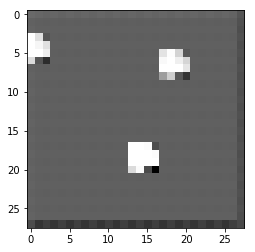

label tensor(3)
Iteration: 94000
Discriminator Cost tensor(0.1218, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1283, grad_fn=<MulBackward>)


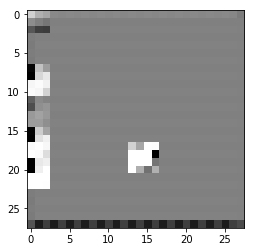

label tensor(8)
Iteration: 95000
Discriminator Cost tensor(0.1249, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1252, grad_fn=<MulBackward>)


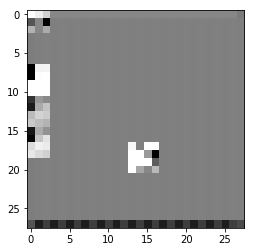

label tensor(7)
Iteration: 96000
Discriminator Cost tensor(0.1251, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1249, grad_fn=<MulBackward>)


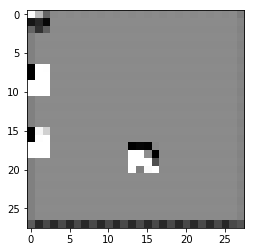

label tensor(8)
Iteration: 97000
Discriminator Cost tensor(0.1248, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1252, grad_fn=<MulBackward>)


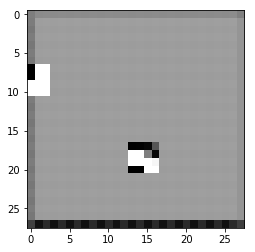

label tensor(6)
Iteration: 98000
Discriminator Cost tensor(0.1197, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1319, grad_fn=<MulBackward>)


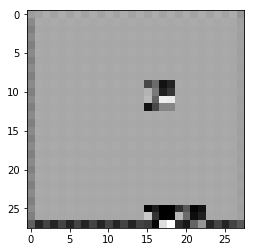

label tensor(5)
Iteration: 99000
Discriminator Cost tensor(0.1354, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1231, grad_fn=<MulBackward>)


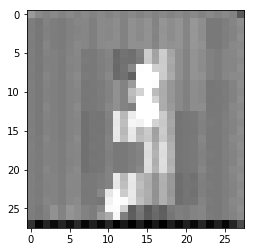

label tensor(2)
Iteration: 100000
Discriminator Cost tensor(0.1294, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1241, grad_fn=<MulBackward>)


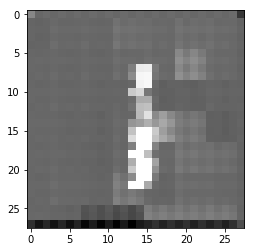

label tensor(2)
Iteration: 101000
Discriminator Cost tensor(0.1303, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1212, grad_fn=<MulBackward>)


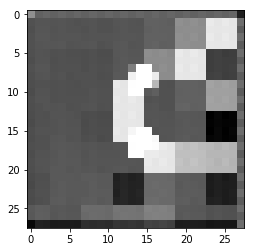

label tensor(1)
Iteration: 102000
Discriminator Cost tensor(0.1299, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1207, grad_fn=<MulBackward>)


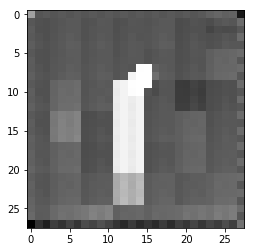

label tensor(8)
Iteration: 103000
Discriminator Cost tensor(0.1185, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1323, grad_fn=<MulBackward>)


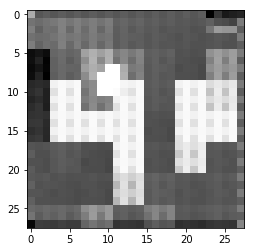

label tensor(0)
Iteration: 104000
Discriminator Cost tensor(0.1256, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1246, grad_fn=<MulBackward>)


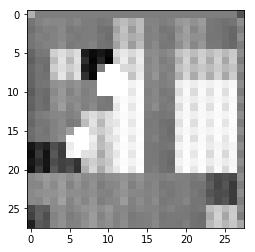

label tensor(8)
Iteration: 105000
Discriminator Cost tensor(0.1256, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1246, grad_fn=<MulBackward>)


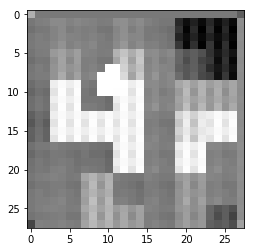

label tensor(7)
Iteration: 106000
Discriminator Cost tensor(0.1243, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1259, grad_fn=<MulBackward>)


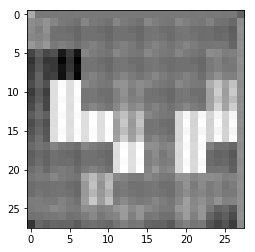

label tensor(9)
Iteration: 107000
Discriminator Cost tensor(0.1276, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1225, grad_fn=<MulBackward>)


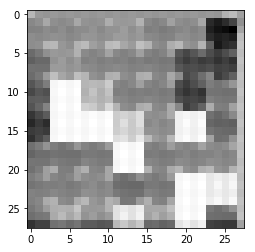

label tensor(6)
Iteration: 108000
Discriminator Cost tensor(0.1252, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1250, grad_fn=<MulBackward>)


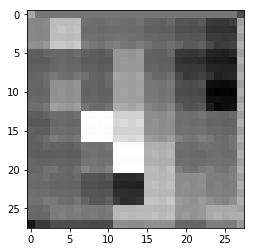

label tensor(8)
Iteration: 109000
Discriminator Cost tensor(0.1240, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1262, grad_fn=<MulBackward>)


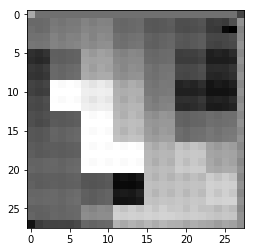

label tensor(5)
Iteration: 110000
Discriminator Cost tensor(0.1262, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1239, grad_fn=<MulBackward>)


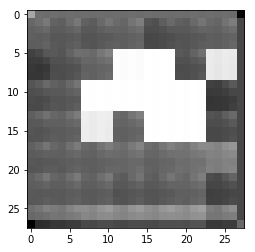

label tensor(7)
Iteration: 111000
Discriminator Cost tensor(0.1257, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1244, grad_fn=<MulBackward>)


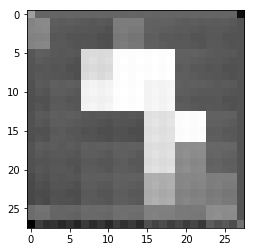

label tensor(5)
Iteration: 112000
Discriminator Cost tensor(0.1259, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1242, grad_fn=<MulBackward>)


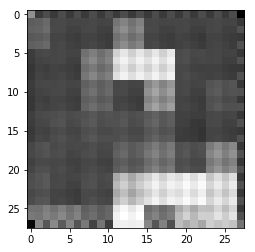

label tensor(6)
Iteration: 113000
Discriminator Cost tensor(0.1254, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1247, grad_fn=<MulBackward>)


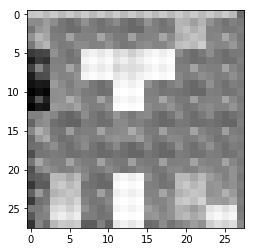

label tensor(6)
Iteration: 114000
Discriminator Cost tensor(0.1272, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1229, grad_fn=<MulBackward>)


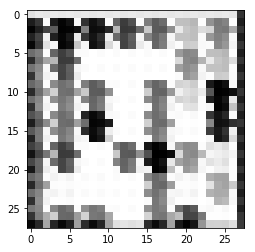

label tensor(9)
Iteration: 115000
Discriminator Cost tensor(0.1239, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1262, grad_fn=<MulBackward>)


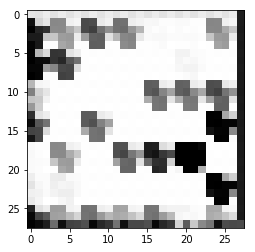

label tensor(9)
Iteration: 116000
Discriminator Cost tensor(0.1232, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1277, grad_fn=<MulBackward>)


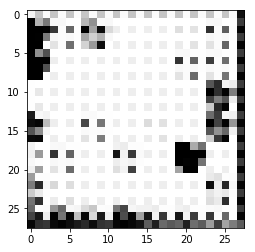

label tensor(4)
Iteration: 117000
Discriminator Cost tensor(0.1270, grad_fn=<ThAddBackward>)
Generator Cost tensor(0.1231, grad_fn=<MulBackward>)


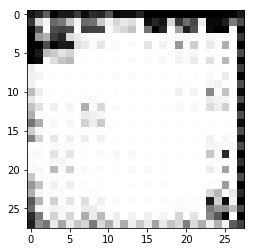

(Generator(
   (conditional_concat): Add_Conditional()
   (layer1): Sequential(
     (0): Linear(in_features=97, out_features=1024, bias=True)
     (1): ReLU()
     (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (layer2): Sequential(
     (0): Linear(in_features=1024, out_features=6272, bias=True)
     (1): ReLU()
     (2): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (unflatten): Unflatten()
   (layer3): Sequential(
     (0): ConvTranspose2d(128, 64, kernel_size=[4, 4], stride=[2, 2], padding=(1, 1))
     (1): ReLU()
     (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (layer4): Sequential(
     (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (1): ConvTranspose2d(64, 1, kernel_size=[4, 4], stride=[2, 2], padding=(1, 1))
     (2): Tanh()
   )
   (flatten): Flatten()
 ), CNN(
   (layer1): Sequential(
     (0):

In [18]:
train_gan(generator, discriminator, image_loader, epochs, num_train_batches=num_train_batches)